Thursday, June 8, 2023

I was running this in the conda environment nlpwt, but then realized it does not have the gpu version of PyTorch ... wtf!?

I am now running this in docker container sad_nightingale.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
torch.__version__

'1.13.1'

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
delimiter = '.'

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi[delimiter] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


Since we have a GPU, let's use it, shall we ... 

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")  # Fallback to CPU if GPU is not available
device

device(type='cuda')

In [8]:
# override the above ... cuz I want to test something ...
device = torch.device("cpu")  

In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
manualSeed = 2147483647

## Model Initialization 1

In [11]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden,                        generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device)
b2 = torch.randn(vocab_size,                      generator=g).to(device)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 1

In [12]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    
# back to the conda nlpwt environment ...
# CPU times: user 8min 24s, sys: 7.84 s, total: 8min 32s
# Wall time: 1min 6s
    
# docker container start sad_nightingale
# No .todevice(device) code
# CPU times: user 9min 24s, sys: 1.2 s, total: 9min 26s
# Wall time: 1min 13s
    
# docker container start sad_nightingale
# This is where we set device to cpu ... device = torch.device("cpu")
# CPU times: user 9min 37s, sys: 1.22 s, total: 9min 38s
# Wall time: 1min 15s
      
# docker container start sad_nightingale
# This is back to adding .to(device) ... where device is cuda.
# CPU times: user 1min 40s, sys: 1.82 s, total: 1min 42s
# Wall time: 1min 53s
    
# docker container start sad_nightingale
# This shows the time after I removed all those .to(device) statements.
# CPU times: user 9min 32s, sys: 1.03 s, total: 9min 33s
# Wall time: 1min 14s
 
# docker container start sad_nightingale    
# Why is this now slower on the GPU?!   
# This is the time when I specify .to(device) when creating each tensor.
# CPU times: user 1min 44s, sys: 1.26 s, total: 1min 45s
# Wall time: 1min 56s
    
# docker container start sad_nightingale
# CPU times: user 9min 18s, sys: 1.04 s, total: 9min 19s
# Wall time: 1min 12s
    
# running on all 8 cpus ... conda nlpwt
# CPU times: user 6min 42s, sys: 5.67 s, total: 6min 48s
# Wall time: 51.6 s
    

      0/ 200000: 27.8817
  10000/ 200000: 2.8331
  20000/ 200000: 2.4988
  30000/ 200000: 2.6304
  40000/ 200000: 2.0544
  50000/ 200000: 2.4894
  60000/ 200000: 2.4372
  70000/ 200000: 2.1040
  80000/ 200000: 2.3070
  90000/ 200000: 2.1245
 100000/ 200000: 1.9729
 110000/ 200000: 2.5353
 120000/ 200000: 2.1414
 130000/ 200000: 2.5304
 140000/ 200000: 2.3557
 150000/ 200000: 2.2075
 160000/ 200000: 2.3027
 170000/ 200000: 1.8006
 180000/ 200000: 2.3113
 190000/ 200000: 2.0539
CPU times: user 9min 34s, sys: 1.18 s, total: 9min 35s
Wall time: 1min 15s


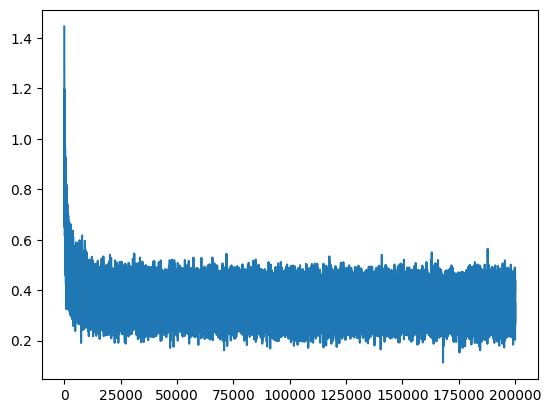

In [13]:
plt.plot(lossi)

## Split Loss 1

In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    # (N, n_hidden)
    h = torch.tanh(embcat @ W1 + b1)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [15]:
split_loss('train')

train 2.2306289672851562


In [16]:
split_loss('val')

val 2.2506215572357178


In [17]:
# sample from the model
g = torch.Generator().manual_seed(manualSeed + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        ttc = torch.tensor([context]).to(device)
        emb = C[ttc] # (1, block_size, n_embed)
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1).to(device)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g) # this blows up here if we use the gpu ... !
        ix = ix.item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, then break
        if ix == 0:
            break
            
    # decode and print the generated word
    print(''.join(itos[i] for i in out))
        

carlah.
amorilli.
kemri.
rehty.
sacessaeja.
huen.
amerync.
kaqui.
nellara.
chaiir.
kaleig.
dham.
jorn.
quinn.
srockon.
jadii.
wazelo.
dearynixfiaun.
durabee.
deai.


## A) Fixing the initial loss

The first thing we are going to scrutinize is the initialization. The first iteration of the training loop reveals a loss of almost 28, followed by the second iteration going down to 2.8. We should have expected something a lot lower for the first iteration, something closer to the second iteration. 

We should expect something closer to a probability distribution of something even for all 27 characters, meaning the model should predict an equal likelihood for any of the 27 characters. (1/27 = 0.037)

In [18]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [19]:
# a 4-dimensional example of the issue ... so we only have 4 characters.
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
# so if the Y label is 2, then ... 
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [20]:
probs.sum()

tensor(1.)

But what if the 2nd example was very high, like 5 ... then we will have a very low loss, 0.02 ...

In [21]:
# a 4-dimensional example of the issue ... so we only have 4 characters.
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 5., 0.]),
 tensor([0.0066, 0.0066, 0.9802, 0.0066]),
 tensor(0.0200))

But its more likely that some other example will have a high value, and then we wil have a higher loss ...

In [22]:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 5., 0., 0.]),
 tensor([0.0066, 0.9802, 0.0066, 0.0066]),
 tensor(5.0200))

In [23]:
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-3.,  5.,  0.,  2.]),
 tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]),
 tensor(5.0553))

What we want is for the logits to be rougly zero when it's initialized, or they just have to be the same value ..

In [24]:
logits = torch.tensor([3.5, 3.5, 3.5, 3.5])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([3.5000, 3.5000, 3.5000, 3.5000]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

So if we take the code from Training Loop 1 and replicate it to Training Loop 2 below, re-run the Model Initialization 1 code, then tweak it to break on the first iteration ...

## Model Initialization 1 (copied from a previous cell)

In [25]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden,                        generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device)
b2 = torch.randn(vocab_size,                      generator=g).to(device)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 2

In [26]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # The only change from Training Loop 1
    break

      0/ 200000: 27.8817
CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 5.85 ms


And now we take a look at the logits from the first row of the output layer ...

In [27]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

... you can see the logits can take on some extreme values. They vary a lot. 

`This is what is creating the fake confidence and incorrect answers and makes the loss get very high!`

So these logits should all be much closer to zero. 

So how do we do this?

Well if we look at the code in the training loop, we can see the logits are calculated as

logits = h @ W2 + b2


The first thing we can so is modify how we initialize b2. Currently we initialize b2 with randn 

b2 = torch.randn(vocab_size,                      generator=g).to(device)

but we want those numbers to all be zero or close to zero. This can be done by multiplying by 0:

b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0

The second thing we can do is also scale down how we initialize W2. Currently we initialize W2 with randn

W2 = torch.randn((n_hidden, vocab_size), generator=g).to(device)

Let's scale down all those numbers by multiplying by 0.1

W2 = torch.randn((n_hidden, vocab_size), generator=g).to(device) * 0.1

## Model Initialization 2

In [28]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden,                        generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.1 # change 2
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 # change 1

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 2 (copied from a previous cell)

In [29]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # The only change from Training Loop 1
    break

      0/ 200000: 4.2326
CPU times: user 170 ms, sys: 0 ns, total: 170 ms
Wall time: 38.7 ms


So now let's run the model initialization 2 code above, re-run the code from training loop 2, then display the logits from row 1.

In [30]:
logits[0]

tensor([-0.2490,  3.5232, -1.2675,  0.5407,  1.6622, -1.1708, -0.1398,  0.1242,
         0.9210,  1.1347,  1.3624, -0.9252,  0.4438, -2.4594, -0.9714,  0.1247,
        -0.9572, -1.3763, -2.3287, -0.1374,  2.4522,  1.6165,  1.6649, -1.0944,
        -2.1544,  0.7255,  1.1413], grad_fn=<SelectBackward0>)

We can now see the training loss on the first iteration is much lower, at 4.2326, and that the logits from the first iteration are all closer to 0.

Ok. That's a good start. But why don't we just multiply W2 by 0.0 to initialize all the weights in W2 to be 0.0?

Let's find out! Replicate the code in Model Initialization 2 into Model Initialization 3, then multiply W2 by zero, display logits[0]

### Model Initialization 3

In [31]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden,                        generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.0 # only change from Model Initialization 2
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


Meh ... let's replicate the code from Training Loop 1 into the cell below .. and then run it. We want the entire loop to run ... so no break after the first pass.

## Training Loop 1 (copied from a previous cell)

In [32]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2958
  10000/ 200000: 2.1886
  20000/ 200000: 2.3954
  30000/ 200000: 2.5034
  40000/ 200000: 1.9946
  50000/ 200000: 2.4849
  60000/ 200000: 2.4794
  70000/ 200000: 2.1435
  80000/ 200000: 2.1880
  90000/ 200000: 2.0427
 100000/ 200000: 2.0054
 110000/ 200000: 2.2827
 120000/ 200000: 1.9648
 130000/ 200000: 2.5441
 140000/ 200000: 2.2898
 150000/ 200000: 2.2020
 160000/ 200000: 1.9903
 170000/ 200000: 1.8524
 180000/ 200000: 2.1030
 190000/ 200000: 1.9201
CPU times: user 10min 49s, sys: 1.26 s, total: 10min 51s
Wall time: 1min 27s


Now the first iteration produces a loss of 3.3, and if we plot the loss lossi we get:

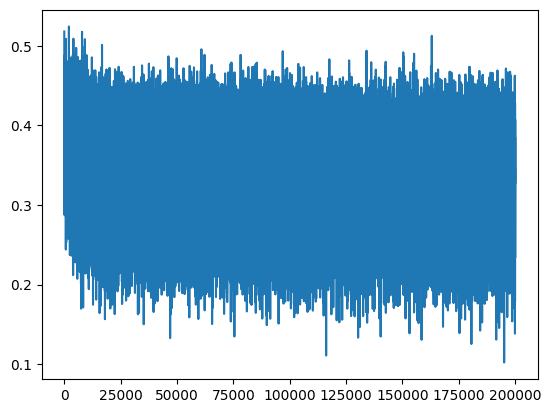

In [33]:
plt.plot(lossi)

Notice we no longer have the 'hockey stick' loss graph, where in the first few iterations of the loss, the optimization is 'squashing down the logits' and then its 'rearranging the logits'. We no longer get the 'easy gains' in the beginning, and the 'hard gains' later. Above we see we are starting with the 'hard gains' right from the beginning, which is what we want.

Now if we display the 'train' and 'val' split loss, we should see an improvement.

## Split Loss 1 (copied from a previous cell)

In [34]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    # (N, n_hidden)
    h = torch.tanh(embcat @ W1 + b1)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1233866214752197
val 2.1638295650482178


This is an improvement from previously where we were getting 2.23 and 2.25. This is because we are spending more iterations on optimizing the neural network instead of spending the first say 1000 iterations squashing down the weights.

## B) Fixing the saturated tanh

The next problem with the code is with the initial values for h:

embcat = emb.view(emb.shape[0], -1)

h = torch.tanh(embcat @ W1 + b1)





Let's plot the values of h into a histogram to see the distribution of values within this tensor:

In [37]:
h.shape

torch.Size([32, 200])

We can view this out and stretch it into one long vector, then call tolist to convert this into one long python list of floats, then pass this into plt.hist and tell it we want 50 bins. The semicolon will suppress printing out a bunch of content we don't want. 

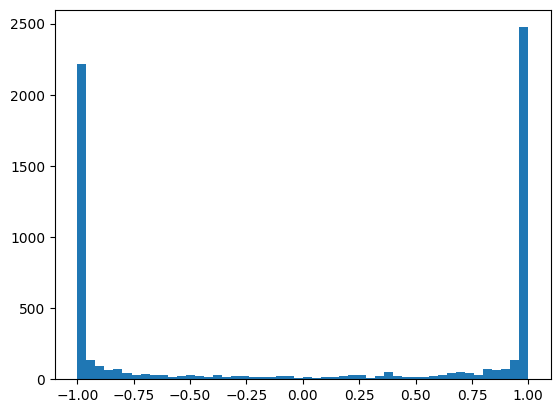

In [39]:
plt.hist(h.view(-1).tolist(), 50);

So you can see from the histogram that most of the values in h take on the value of -1 or 1. 

We can also feed the pre-activations into the histogram in the same manner.

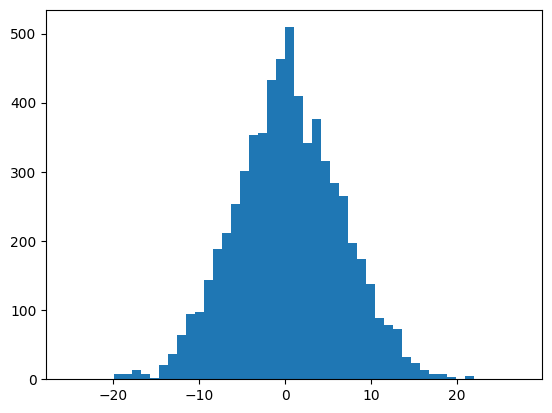

In [40]:
plt.hist(hpreact.view(-1).tolist(), 50);

You can see the pre-activations that we feed into the tanh take on a distribution that is very broad, between -20ish and 20ish. 

![tanh](images/tanh.png)

Recall when we do back propogation through the network, we will back prop through the tanh function, and if the value we feed into tanh is very close to 1 or -1, then looking at the above code, you can see we are 'killing the gradient' and effectively stopping back prop through this tanh unit. 

To get an idea of how much our h values are around -1 or 1, we can plot the values in an image ...

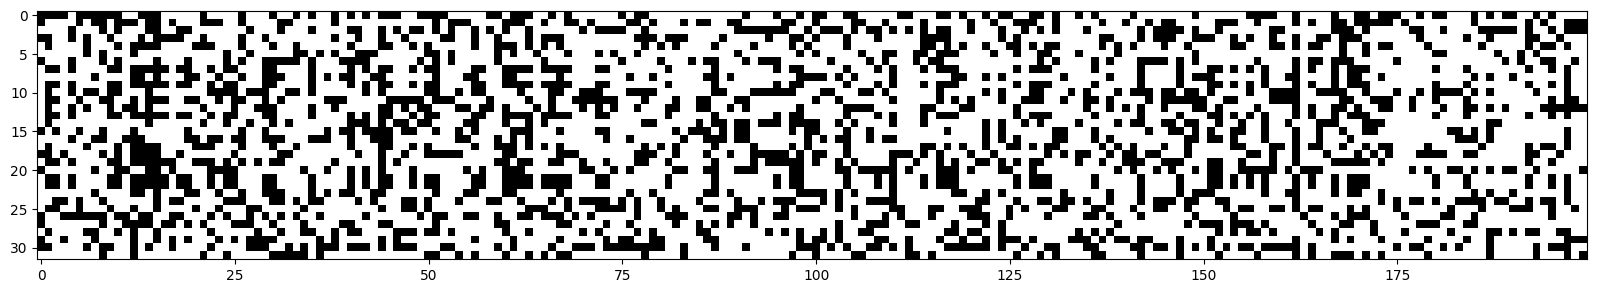

In [41]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In the above image, we see white if h.abs() > 0.99, otherwise we see black. 

If any column was all white, then we would have a dead neuron, and nothing could pass through it. It would never learn.

The solution is for the initial values in hpreact to be closer to zero.

So let's tweak the Model Initialization code to do this:

## Model Initialization 4

In [43]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device) * 0.1  # tweak 3
b1 = torch.randn(n_hidden,                        generator=g).to(device) * 0.01 # tweak 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.01 # a slight tweak to not have zero
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 2 (copied again from a previous cell)

In [44]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # The only change from Training Loop 1
    break

      0/ 200000: 3.3069
CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 23.9 ms


Re run both histograms:

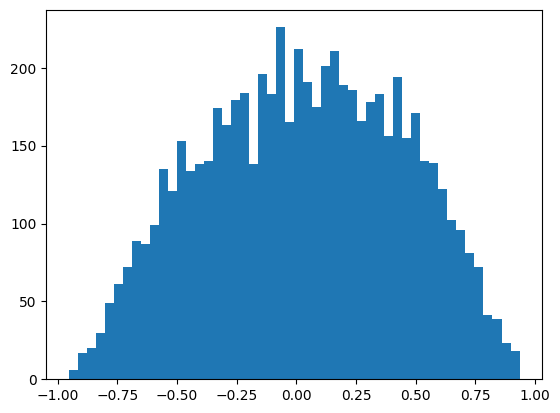

In [45]:
plt.hist(h.view(-1).tolist(), 50);

This is a much better histogram with no saturation on -1 or 1.

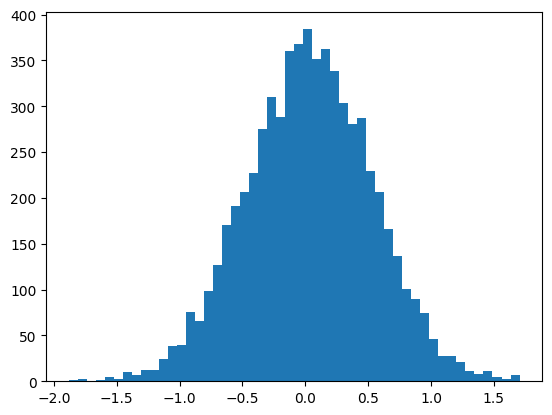

In [46]:
plt.hist(hpreact.view(-1).tolist(), 50);

And the pre-activations are now between -1.5 and 1.5, instead of between -20ish and 20ish.

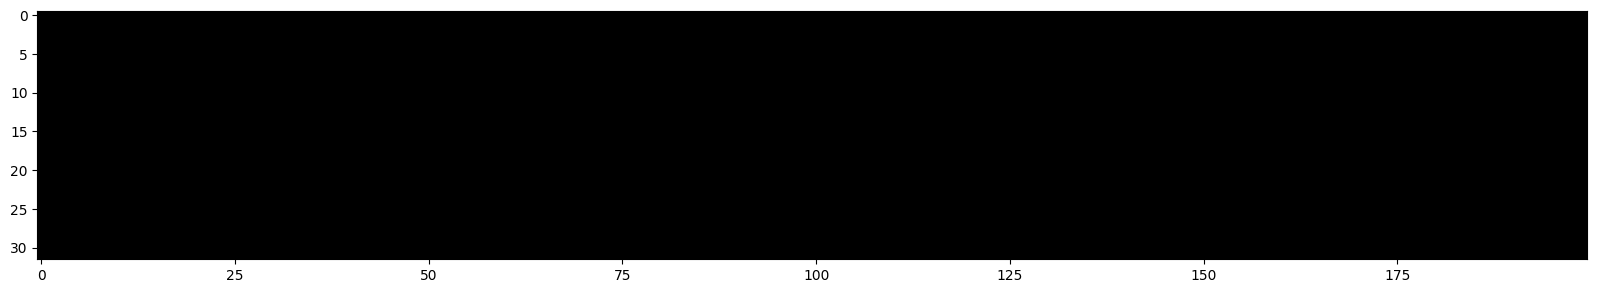

In [47]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

The above we expect a lot less white. There is no white! That's because there are no neurons that saturated above .99 in either direction.

Hmmm ... lets try another small tweak to the Model Initialization code:

## Model Initialization 5

In [48]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device) * 0.2  # the only tweak!
b1 = torch.randn(n_hidden,                        generator=g).to(device) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.01 
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 2 (copied again from a previous cell)

In [49]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # The only change from Training Loop 1
    break

      0/ 200000: 3.3135
CPU times: user 238 ms, sys: 0 ns, total: 238 ms
Wall time: 39.2 ms


And now rerun that image ...

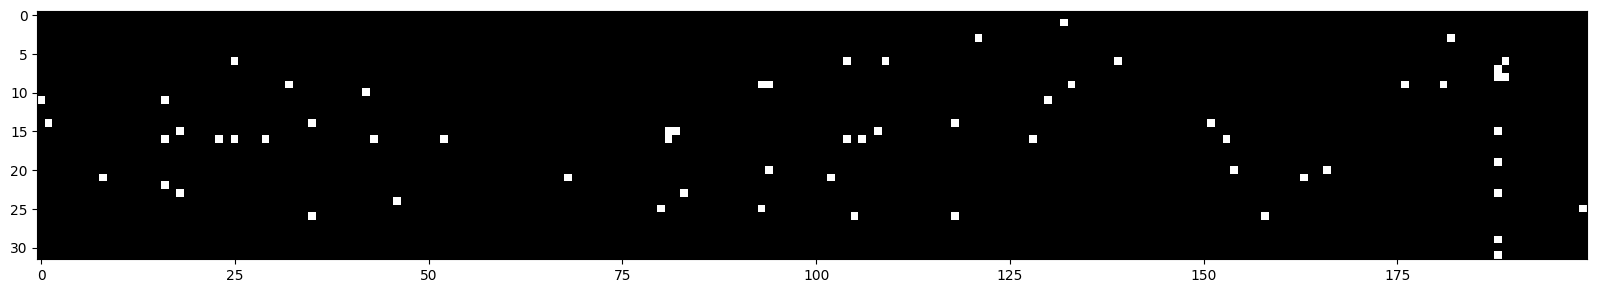

In [50]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

... and both histograms:

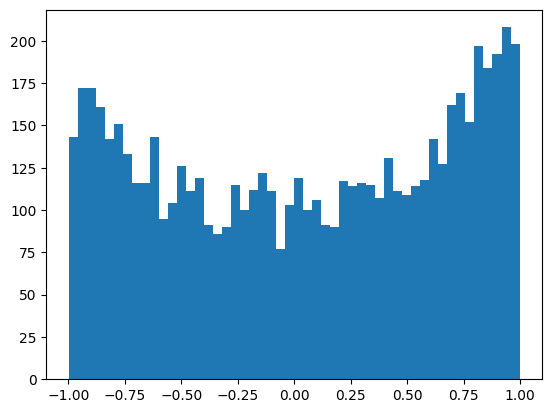

In [51]:
plt.hist(h.view(-1).tolist(), 50);

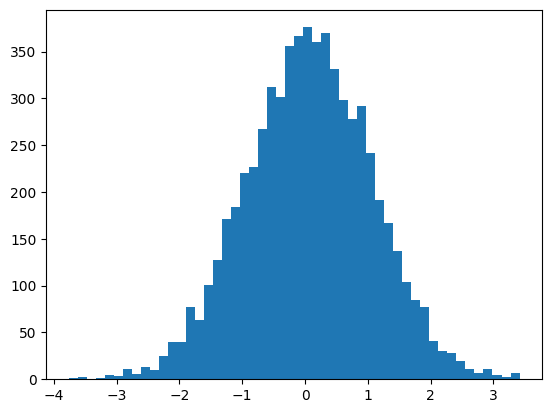

In [52]:
plt.hist(hpreact.view(-1).tolist(), 50);

So knowing what we now know, let's re-run a full training of the data!

## Model Initialization 5 (copied from a previous cell)

In [53]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device) * 0.2  # the only tweak!
b1 = torch.randn(n_hidden,                        generator=g).to(device) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device) * 0.01 
b2 = torch.randn(vocab_size,                      generator=g).to(device) * 0.0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


## Training Loop 1 (copied again from a previous cell)

In [54]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.2440
  30000/ 200000: 2.3044
  40000/ 200000: 1.9598
  50000/ 200000: 2.4266
  60000/ 200000: 2.3693
  70000/ 200000: 2.0370
  80000/ 200000: 2.2545
  90000/ 200000: 2.1047
 100000/ 200000: 1.8406
 110000/ 200000: 2.1954
 120000/ 200000: 2.0199
 130000/ 200000: 2.4290
 140000/ 200000: 2.2683
 150000/ 200000: 2.1892
 160000/ 200000: 1.8254
 170000/ 200000: 1.7761
 180000/ 200000: 1.9963
 190000/ 200000: 1.8334
CPU times: user 9min 48s, sys: 1.24 s, total: 9min 49s
Wall time: 1min 17s


In [55]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    # (N, n_hidden)
    h = torch.tanh(embcat @ W1 + b1)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.081057548522949
val 2.125427722930908


In [ ]:
# Here is a summary of how the loss on the training and validation data improved:

# No changes to the Model Initialization
# train 2.2306289672851562
# val 2.2506215572357178

# A) Fix the Initial loss (fix softmas confidently wrong)
# train 2.1233866214752197
# val 2.1638295650482178

#B) Fix the saturated tanh (fix tanh layer saturated at init)
# train 2.081057548522949
# val 2.125427722930908
